## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix

In [2]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = cv2.imread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration3.jpg


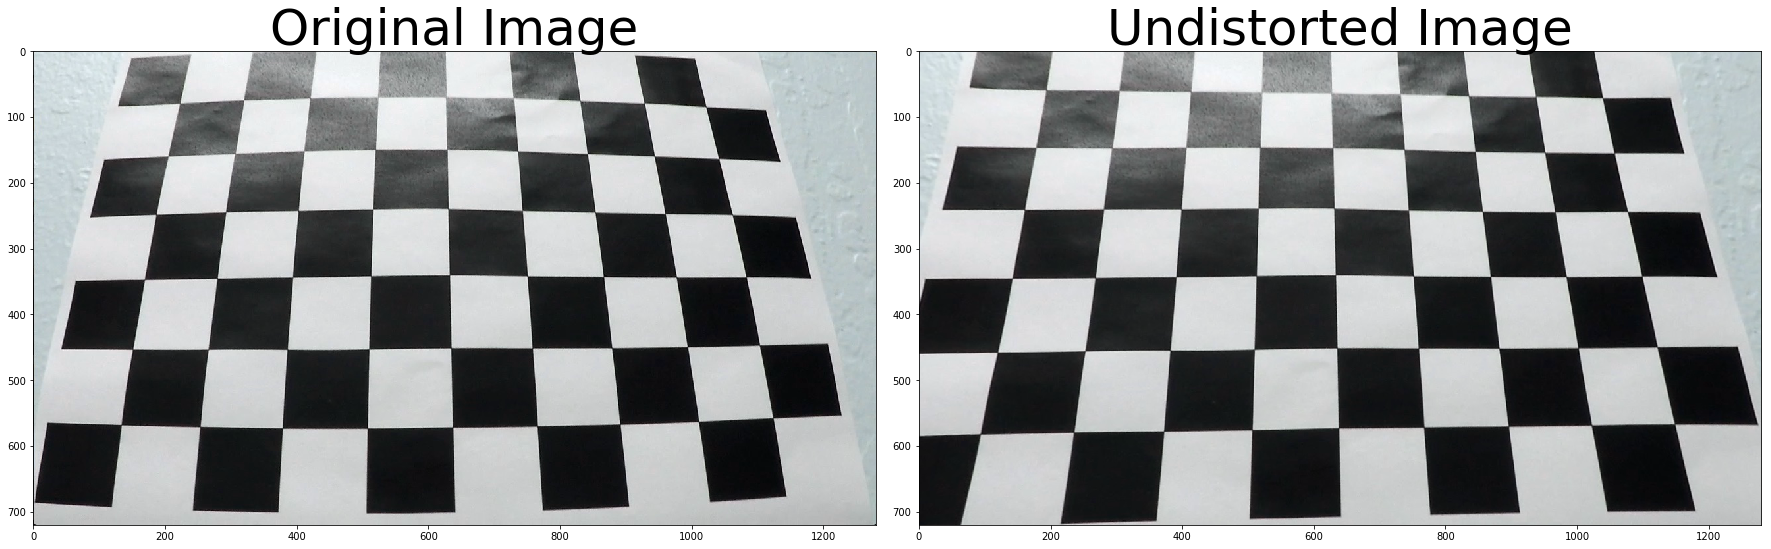

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = cv2.imread(pers_img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    src = np.float32([[603, 444], [675, 444], [1050, 688], [253, 688]])
    dst = np.float32([[250, 0], [1050, 0], [1050, 700], [250, 700]])
    '''
          1   2
           ---
          /   \
         /     \
        /       \
        ---------
       4         3 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


..\test_images\straight_lines1.jpg


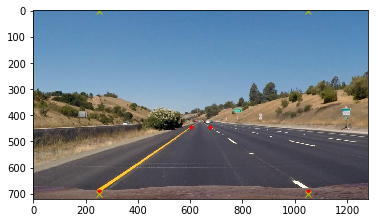

In [6]:
M, Minv = get_perspective_transform_mtx()

In [7]:
def testimg_perspective_transform(m):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = cv2.imread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

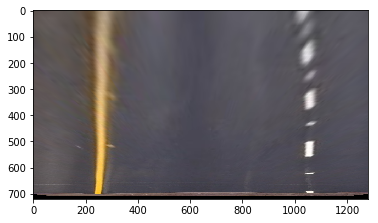

In [8]:
testimg_perspective_transform(M)   

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [9]:
from cv2 import Sobel

def build_binary_img(img, rawtype = 'bgr', orient = 'x', sobeltype = 's', s_thresh = (170, 255), sobel_thresh = (20, 100)):
    if rawtype == 'rgb': # cv2.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif rawtype == 'bgr': # matplotlib.image.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:  # gray
        assert 0

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    channel = gray
    sobelx = Sobel(channel, cv2.CV_64F, 1, 0)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    
    sobely = Sobel(channel, cv2.CV_64F, 0, 1)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))

    # sobel_thresh = (20, 100)
    sobel_bin = np.zeros_like(sobelx)
    if orient == 'x':
        sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 1
    else:
        sobel_bin[(sobely >= sobel_thresh[0]) & (sobely <= sobel_thresh[1])] = 1
        
    channel = S
    color_bin = np.zeros_like(channel)
    if orient == 'x':
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    else:
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1

    combined_bin = np.zeros_like(gray)
    combined_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

#     sobel_bin = np.dstack(sobel_bin*3) *255
#     color_bin = np.dstack(color_bin*3) *255
#     combined_bin = np.dstack(combined_bin*3) *255
    
    return sobel_bin*255, color_bin*255, combined_bin*255

In [10]:
def testimg_build_binary():
    # test the function build_binary_image()
    images = glob.glob('../test_images/*.jpg')
    testidx = np.random.randint(0, len(images))
    print('testing the binary img build function on test image ', images[testidx])
    img = cv2.imread(images[testidx])

    img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )

    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
    ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    ax[0][1].set_title('perspective transformed img', fontsize=32)
    
    ax[0][2].imshow(img1, cmap = 'gray')
    ax[0][2].set_title('gray sobel x Image', fontsize=32)

    ax[1][0].imshow(img2, cmap = 'gray')
    ax[1][0].set_title('s color channel Image', fontsize=32)

    ax[1][1].imshow(img3, cmap = 'gray')
    ax[1][1].set_title('combin bin Image', fontsize=32)

    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # img, img0 are color imgs
    # img1, img2, img3 are gray imgs
    return img, img0, img1, img2, img3

testing the binary img build function on test image  ../test_images\test3.jpg


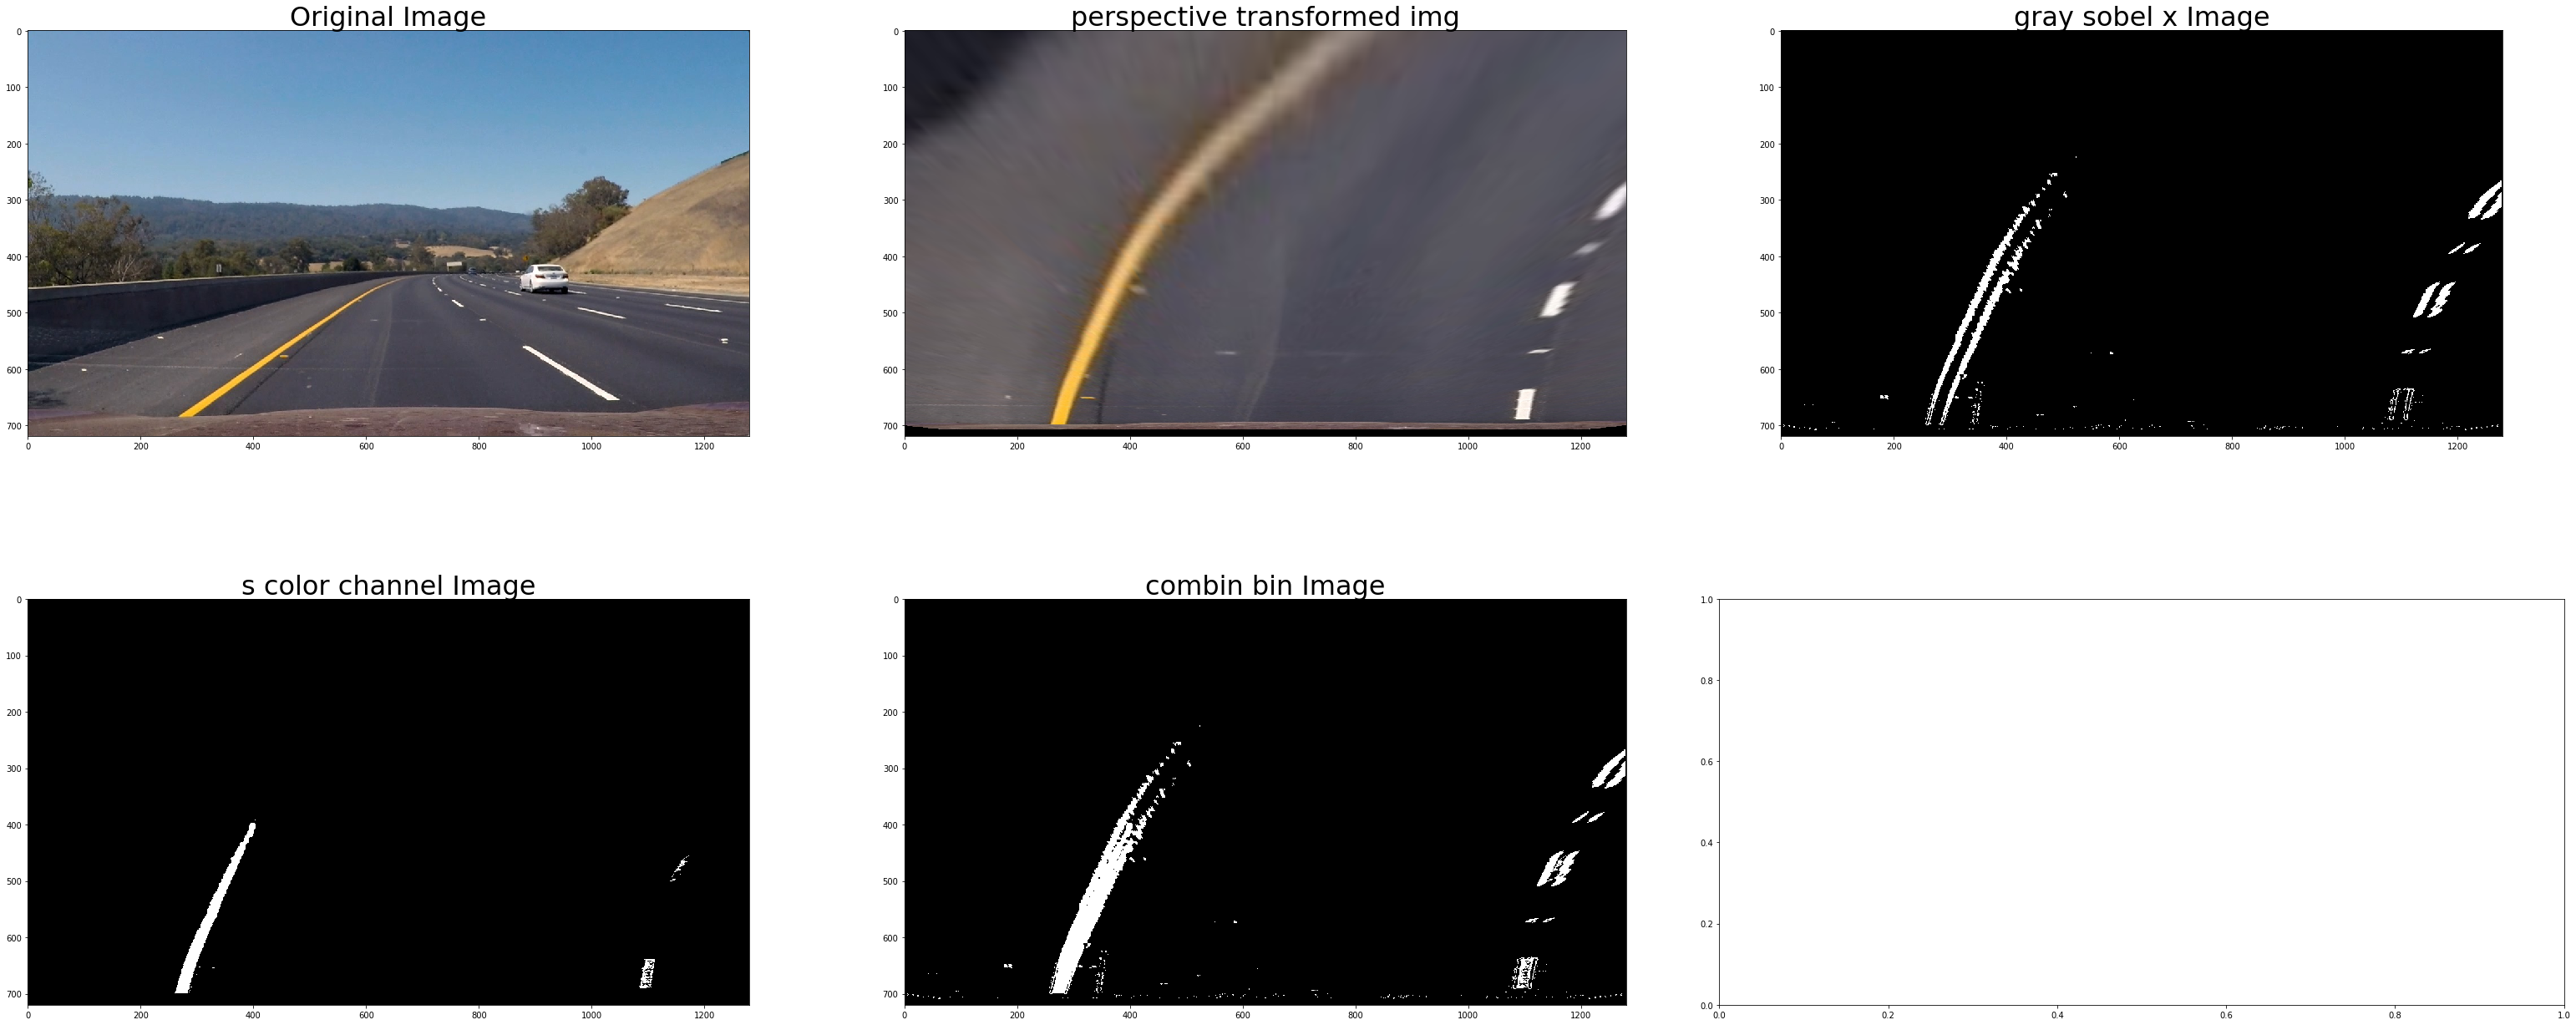

In [11]:
rawimg, img0, img1, img2, img3 = testimg_build_binary()

### 5. Detect lane pixels and fit to find the lane boundary.

In [61]:

def get_histogram(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    histogram = np.sum(img[:,:], axis=0)
    out_img = np.dstack((img, img, img))
    plt.imshow(out_img)
    plt.show()
    plt.plot(histogram)
    plt.show()    
    return histogram

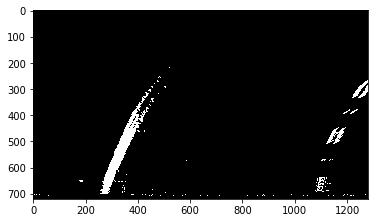

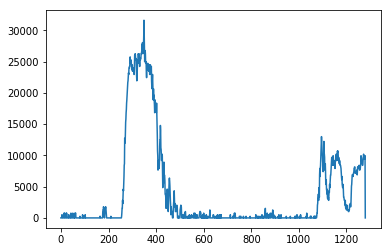

In [62]:
# img is the raw color img,
# img0 is the perspectived img
# img1 is the sobel x binary img
# img2 is the color threshold img
# img3 is the combination of img2 and img3

histogram = get_histogram(img3)

Sliding Window

In [63]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img3.shape


class LaneLineHandler(object):
    def __init__(self):
        self.nwindows = 9
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 100
        self.minpix = 50
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
        
        
    def readin(self, img):
        # readin the raw color image taken from the camera
        
        self.raw = img
        img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )
        
        self.histogram = get_histogram(img3)
        # print(self.histogram.shape)
        self.midpoint = np.int(self.histogram.shape[0]/2)
        self.leftx_base = np.argmax(self.histogram[:self.midpoint])
        self.rightx_base = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
        # print('left base is: ', self.leftx_base, ' right base is: ', self.rightx_base)

        # out_color is color image
        self.out_color = np.dstack((img3, img3, img3))
        
        self.nonzero = self.out_color.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])
        # print('non zero points in x: ', len(self.nonzerox))
        self.leftx_current = self.leftx_base
        self.rightx_current = self.rightx_base
    
    def showOutImg(self):
        plt.imshow(self.out_color)
        
    def slidingWindow(self, plotRectangle = True):
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.out_color.shape[0] - (window+1)*self.window_height
            win_y_high = self.out_color.shape[0] - window*self.window_height
            win_xleft_low = self.leftx_current - self.margin
            win_xleft_high = self.leftx_current + self.margin
            win_xright_low = self.rightx_current - self.margin
            win_xright_high = self.rightx_current + self.margin
            # Draw the windows on the visualization image
            if plotRectangle:
                cv2.rectangle(self.out_color,
                              (win_xleft_low, win_y_low), (win_xleft_high,win_y_high),
                              (0,255,0), 3) 
                # print('build a rectangle : (', win_xleft_low, win_y_low, '), (', win_xleft_high, win_y_high,')')
                cv2.rectangle(self.out_color,
                              (win_xright_low,win_y_low),(win_xright_high,win_y_high), 
                              (0,255,0), 3) 
            # print('build a rectangle : (', win_xright_low, win_y_low, '), (', win_xright_high, win_y_high,')')
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                              (self.nonzerox >= win_xleft_low) &  (self.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                               (self.nonzerox >= win_xright_low) &  (self.nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            # print(good_left_inds.shape, good_right_inds.shape)
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            # print('len good_left_inds is: ', len(good_left_inds))
            if len(good_left_inds) > self.minpix:
                self.leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            # print('len good_right_inds is: ', len(good_right_inds))
            if len(good_right_inds) > self.minpix:
                self.rightx_current = np.int(np.mean(self.nonzerox[good_right_inds]))
            
            # mark left lane pixels as red, right lane [ixels as blue]
    def markLanepixelColor(self):
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        self.out_color[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_color[self.nonzeroy[self.right_lane_inds],self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
    
    def fitting(self):
        # Extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds] 
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        self.left_fit_meter = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
    def showFitting(self):
        # Generate x and y values for plotting
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        plt.imshow(self.out_color)
        plt.plot(self.left_fitx, ploty, color='yellow')
        plt.plot(self.right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    def nextFitting(self, newimg):
        # quick find the fitting of the new image based on the new image
        nonzero = newimg.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # margin = 100
        left_lane_inds = (
            (nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) &
            (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        right_lane_inds = (
            (nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) & 
            (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
    
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(self.righty * self.ym_perpix, slef.rightx * self.xm_per_pix, 2)
        # Generate x and y values for plotting
        # ploty = np.linspace(0, img3.shape[0]-1, img3.shape[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
    
    # after a new raw file read in, do the fitting based on the new image
    def showFitting2(self):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((self.raw , self.raw, self.raw))
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    
    def calcCurvature(self):
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|

        self.left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        y_eval = y_eval * self.ym_per_pix
        self.left_curverad_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curverad_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        print('left curvature is: ', self.left_curverad, ' pixels, e.g, ', self.left_curverad_meter, ' meters')
        print('right curvature is: ', self.right_curverad, ' pixels, e.g, ', self.right_curverad_meter, ' meters')
    
    def drawBack(self):
        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.raw).astype(np.uint8)
        # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
            
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (imgsize[1], imgsize[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.raw, 1, newwarp, 0.3, 0)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        return result
    
    def run(self, img):
        self.readin(img)
        self.slidingWindow(plotRectangle = False)
        self.markLanepixelColor()
        self.fitting()
        self.calcCurvature()
        result = self.drawBack()
        return result

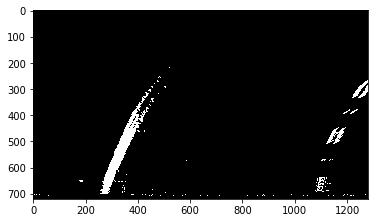

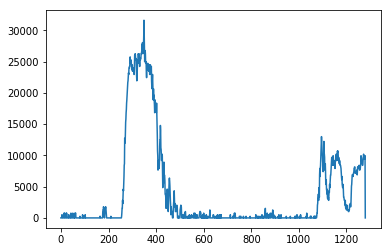

left curvature is:  1233.61413088  pixels, e.g,  370.2503683  meters
right curvature is:  780.04157085  pixels, e.g,  250.41977607  meters


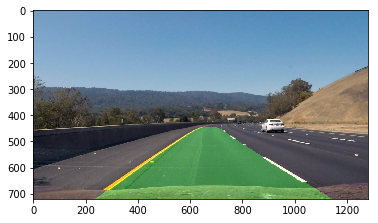

In [68]:
handler = LaneLineHandler()
result = handler.run(rawimg)

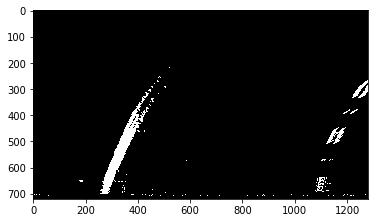

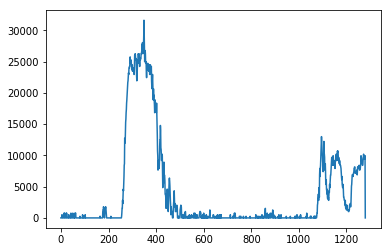

In [69]:
handler = LaneLineHandler()
handler.readin(rawimg)

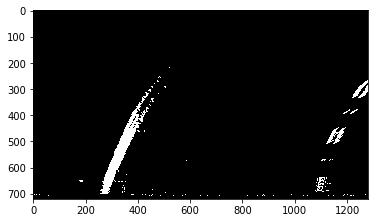

In [70]:
handler.showOutImg()

In [71]:
handler.slidingWindow()

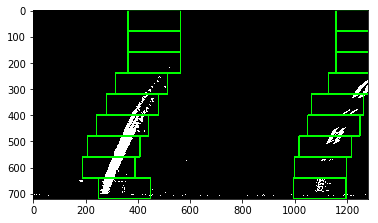

In [72]:
handler.showOutImg()

In [73]:
handler.markLanepixelColor()

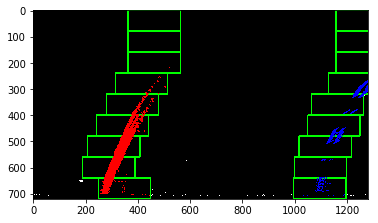

In [74]:
handler.showOutImg()

In [75]:
handler.fitting()

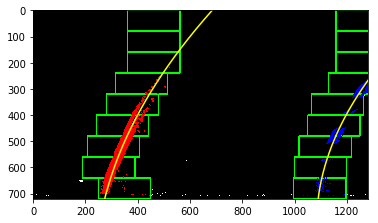

In [76]:
handler.showFitting()

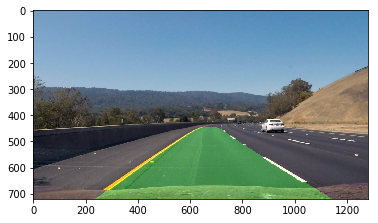

In [78]:
result = handler.drawBack()

### 7. Warp the detected lane boundaries back onto the original image.

In [79]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

In [80]:
# function for video handling
def process_image(img):
    handler = LaneLineHandler()
    result = handler.run(img)
    return result

../output_images\test1.jpg


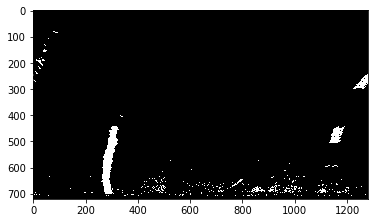

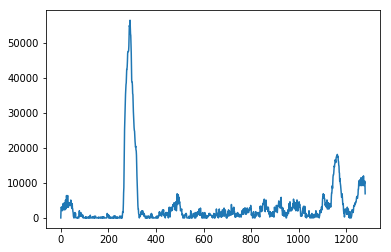

left curvature is:  492.074513547  pixels, e.g,  152.684656868  meters
right curvature is:  549.038073786  pixels, e.g,  172.16909536  meters
../output_images\test2.jpg


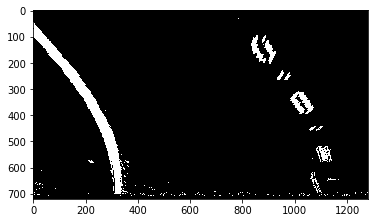

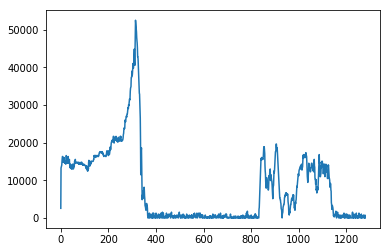

left curvature is:  663.696199185  pixels, e.g,  217.731371199  meters
right curvature is:  730.02274125  pixels, e.g,  114.886374031  meters
../output_images\test3.jpg


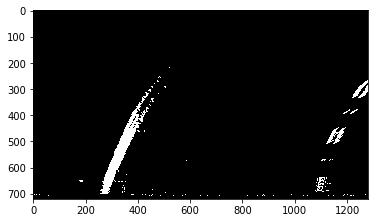

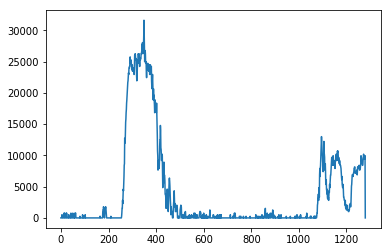

left curvature is:  1233.61413088  pixels, e.g,  370.2503683  meters
right curvature is:  780.04157085  pixels, e.g,  250.41977607  meters
../output_images\test4.jpg


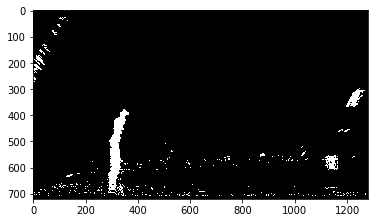

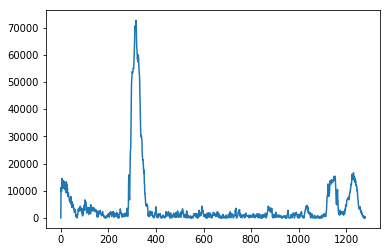

left curvature is:  811.71753774  pixels, e.g,  259.969449166  meters
right curvature is:  434.053312168  pixels, e.g,  96.0653848763  meters
../output_images\test5.jpg


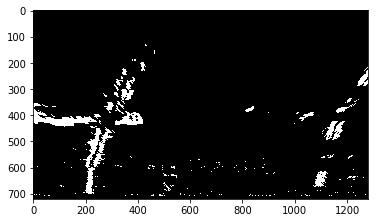

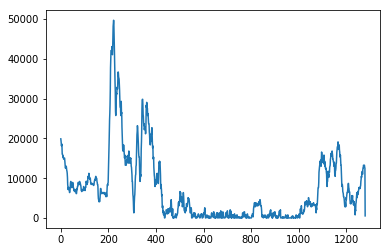

left curvature is:  483.218747043  pixels, e.g,  143.685147581  meters
right curvature is:  478.274808942  pixels, e.g,  142.919714086  meters
../output_images\test6.jpg


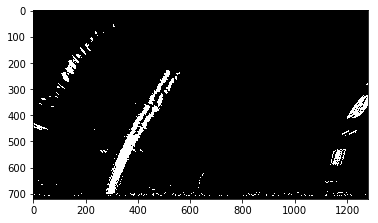

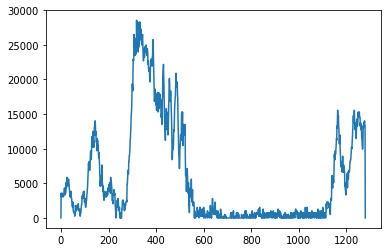

left curvature is:  1156.73157604  pixels, e.g,  340.428038183  meters
right curvature is:  561.34014453  pixels, e.g,  183.990679692  meters


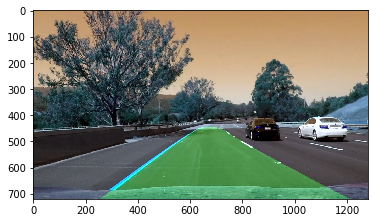

In [81]:
imgnames = glob.glob('../test_images/test*.jpg')
for imgname in imgnames:
#     img = cv2.imread(imgname)
#     result = process_image(img)
    dirname, filename = os.path.split(imgname)
    newimgname = os.path.join('../output_images', filename)
    print(newimgname)
    img = cv2.imread(imgname)
    result = process_image(img)
    plt.imshow(result)
    
    cv2.imwrite(newimgname, result)

                   

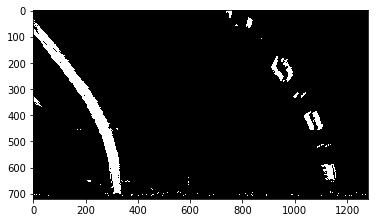

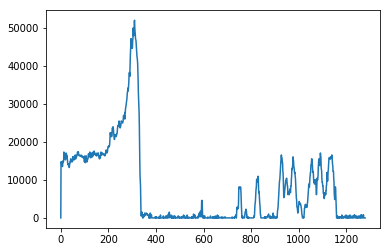

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4



  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

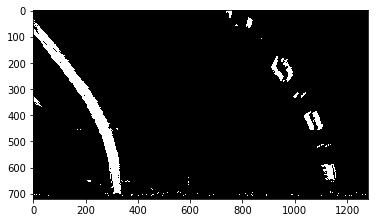

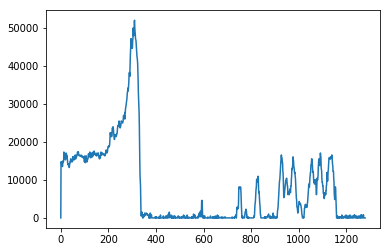

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters



  0%|                                                                                 | 1/1261 [00:00<13:05,  1.60it/s]

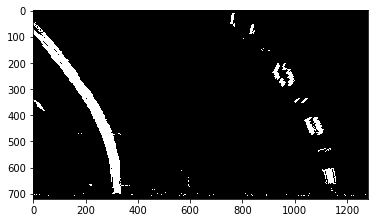

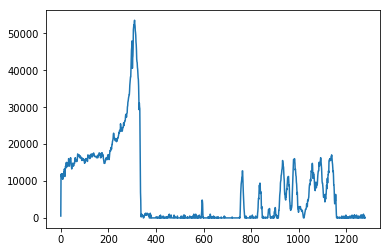

left curvature is:  658.881413406  pixels, e.g,  216.408698922  meters
right curvature is:  932.047175762  pixels, e.g,  297.279403518  meters



  0%|▏                                                                                | 2/1261 [00:01<13:11,  1.59it/s]

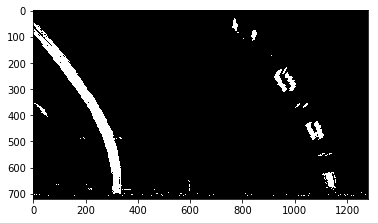

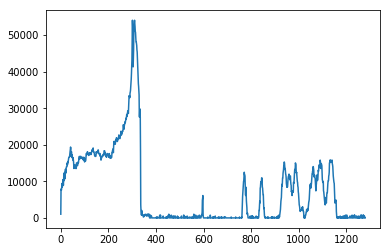

left curvature is:  663.393007811  pixels, e.g,  217.864776533  meters
right curvature is:  692.989376962  pixels, e.g,  226.218968609  meters



  0%|▏                                                                                | 3/1261 [00:01<12:47,  1.64it/s]

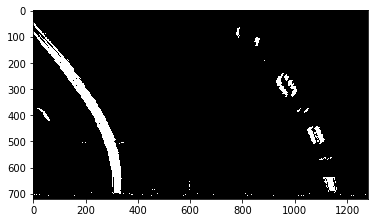

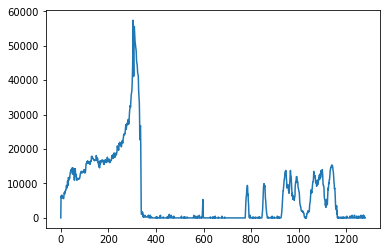

left curvature is:  635.708728019  pixels, e.g,  208.80064373  meters
right curvature is:  759.433019142  pixels, e.g,  243.983795152  meters



  0%|▎                                                                                | 4/1261 [00:02<13:27,  1.56it/s]

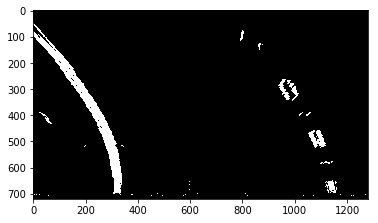

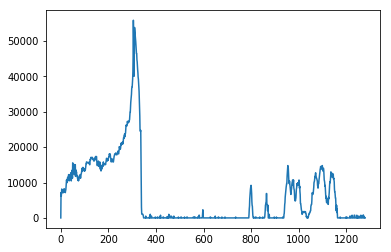

left curvature is:  659.36017742  pixels, e.g,  216.362786164  meters
right curvature is:  481.107778576  pixels, e.g,  149.158469261  meters



  0%|▎                                                                                | 5/1261 [00:03<13:19,  1.57it/s]

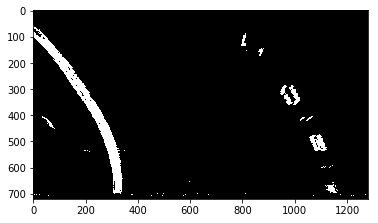

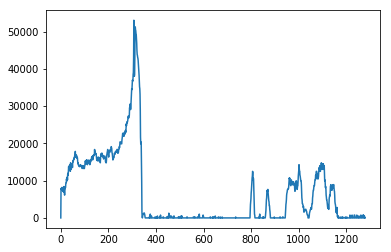

left curvature is:  684.280779221  pixels, e.g,  224.061276091  meters
right curvature is:  821.975440778  pixels, e.g,  259.924195802  meters



  0%|▍                                                                                | 6/1261 [00:03<12:49,  1.63it/s]

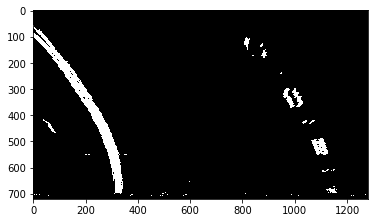

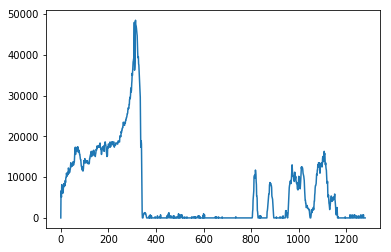

left curvature is:  725.339381345  pixels, e.g,  236.351502319  meters
right curvature is:  785.460860146  pixels, e.g,  250.199875716  meters



  1%|▍                                                                                | 7/1261 [00:04<12:57,  1.61it/s]

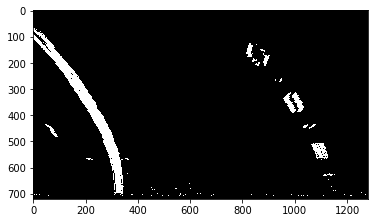

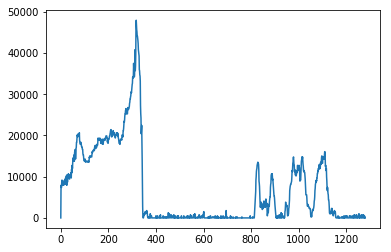

left curvature is:  716.821278552  pixels, e.g,  233.269619576  meters
right curvature is:  845.396413774  pixels, e.g,  265.407158583  meters



  1%|▌                                                                                | 8/1261 [00:04<12:21,  1.69it/s]

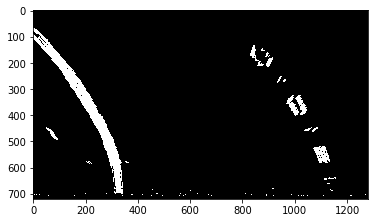

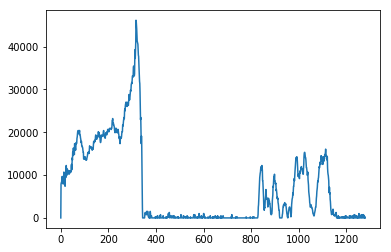

left curvature is:  758.382221701  pixels, e.g,  245.289293052  meters
right curvature is:  815.104520316  pixels, e.g,  257.826440211  meters



  1%|▌                                                                                | 9/1261 [00:05<12:24,  1.68it/s]

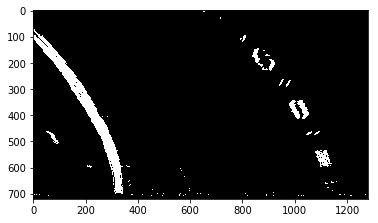

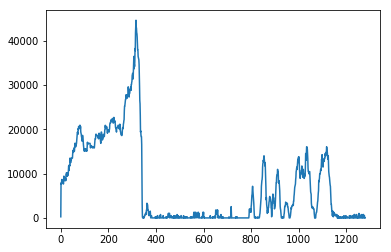

left curvature is:  783.258902565  pixels, e.g,  251.910041913  meters
right curvature is:  701.449461534  pixels, e.g,  227.635466267  meters



  1%|▋                                                                               | 10/1261 [00:06<12:21,  1.69it/s]

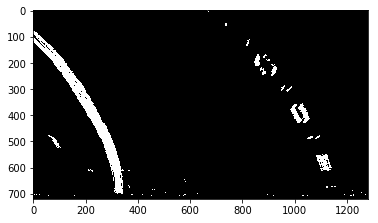

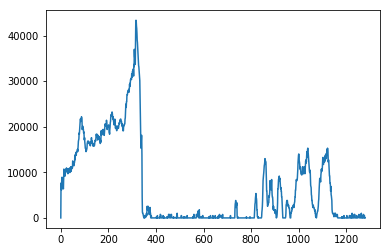

left curvature is:  762.522483518  pixels, e.g,  245.702971562  meters
right curvature is:  718.5336253  pixels, e.g,  231.147715639  meters



  1%|▋                                                                               | 11/1261 [00:06<12:27,  1.67it/s]

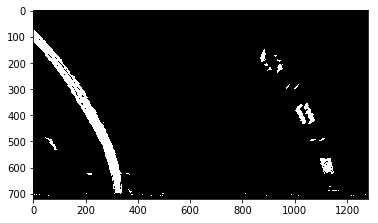

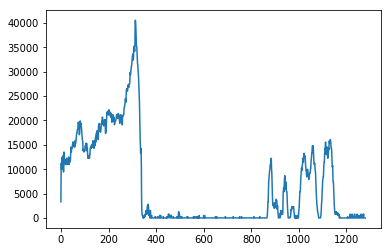

left curvature is:  892.878285316  pixels, e.g,  281.23872582  meters
right curvature is:  1067.55444029  pixels, e.g,  331.41801448  meters



  1%|▊                                                                               | 12/1261 [00:07<12:35,  1.65it/s]

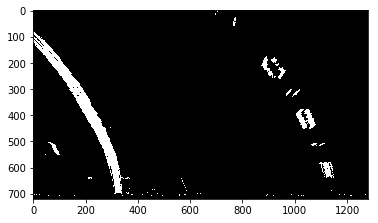

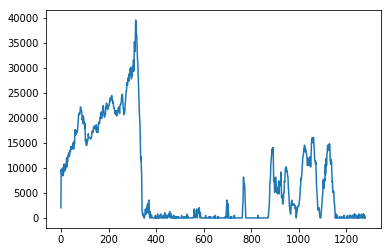

left curvature is:  858.533708382  pixels, e.g,  271.811713547  meters
right curvature is:  718.651731995  pixels, e.g,  233.62506956  meters



  1%|▊                                                                               | 13/1261 [00:07<12:45,  1.63it/s]

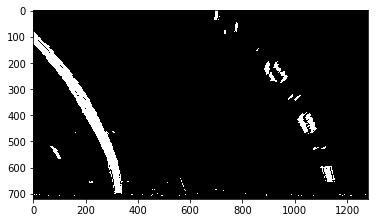

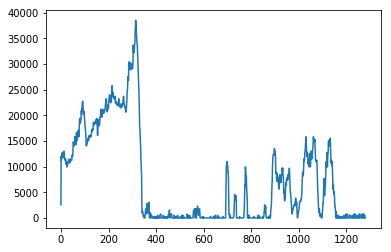

left curvature is:  814.135664531  pixels, e.g,  259.573939404  meters
right curvature is:  745.217874063  pixels, e.g,  241.292488536  meters



  1%|▉                                                                               | 14/1261 [00:08<12:34,  1.65it/s]

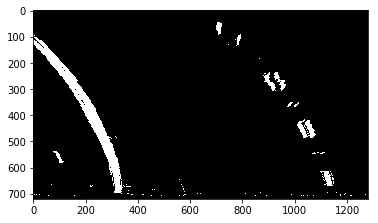

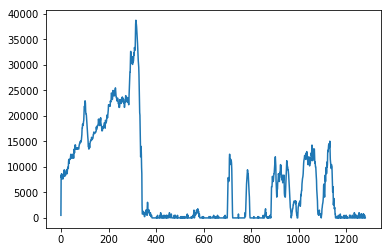

left curvature is:  734.375443986  pixels, e.g,  237.057396597  meters
right curvature is:  1017.72908129  pixels, e.g,  305.245957078  meters



  1%|▉                                                                               | 15/1261 [00:09<12:53,  1.61it/s]

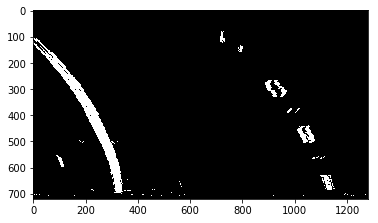

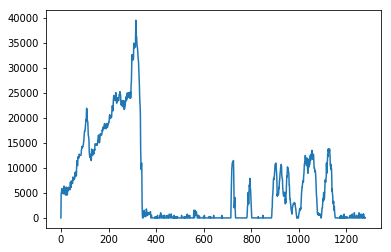

left curvature is:  690.137558639  pixels, e.g,  224.187297398  meters
right curvature is:  923.93503233  pixels, e.g,  275.799872561  meters



  1%|█                                                                               | 16/1261 [00:09<12:54,  1.61it/s]

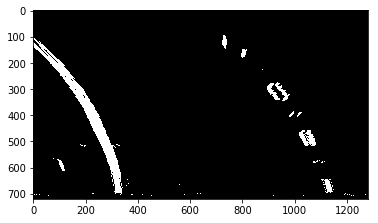

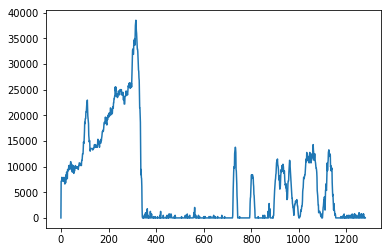

left curvature is:  663.079832686  pixels, e.g,  216.057057885  meters
right curvature is:  899.834435176  pixels, e.g,  271.479872428  meters



  1%|█                                                                               | 17/1261 [00:10<12:37,  1.64it/s]

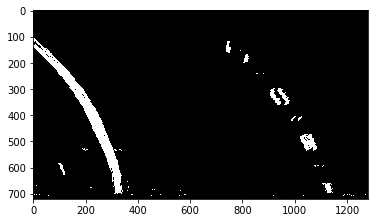

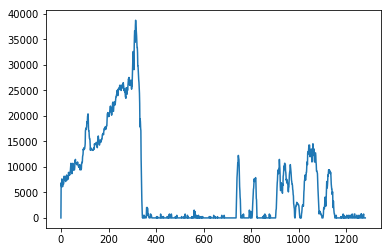

left curvature is:  653.755911267  pixels, e.g,  213.19314657  meters
right curvature is:  987.080728495  pixels, e.g,  291.454822778  meters



  1%|█▏                                                                              | 18/1261 [00:11<13:06,  1.58it/s]

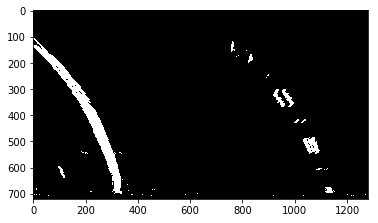

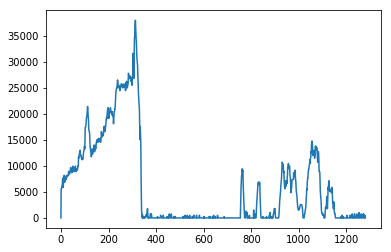

left curvature is:  687.178513576  pixels, e.g,  

In [ ]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip(video_input)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(video_output, audio=False)